Necessary Standard Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, roc_curve, auc, f1_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns

Importing the Custom 

In [2]:
custom_modules_path = os.path.abspath(r'F:\Capstone\DFCA')

# Add the path to sys.path
if custom_modules_path not in sys.path:
    sys.path.append(custom_modules_path)

from scripts.pretrain_pipeline import FusedModel
from utils.augmentations import ComposeT, ToTensor, SpecTimePitchWarp, SpecAugment, GradCAM
from models.heads import AnomalyScorer, SimpleAnomalyMLP, EmbeddingMLP,ComplexAnomalyMLP
from models.losses import ContrastiveLoss, BinaryFocalLoss, FocalLoss
from utils.datasets import PairedSpectrogramDataset, PairedSpectrogramDatasetCS

f:\CapStone\DFCA\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metrics and GradCam Utilities

In [3]:
def calculate_pAUC(labels, preds, max_fpr = 0.1):
    """
    Calculates Partial AUC (pAUC) for a given FPR range.
    Args:
        labels (array): True binary labels.
        preds (array): Predicted probabilities for the positive class.
        max_fpr (float): Maximum False Positive Rate for pAUC calculation.
    Returns:
        float: pAUC score.
    """
    if len(np.unique(labels)) < 2:
        return float('nan')
    
    fpr, tpr, _ = roc_curve(labels, preds)
    #filter for FPR <= max_fpr
    mask = fpr <= max_fpr
    fpr_filtered, tpr_filtered = fpr[mask], tpr[mask] 
      
    if fpr_filtered.size == 0:
        return 0.0

    if fpr_filtered.max() < max_fpr:
        idx = np.where(fpr <= max_fpr)[0][-1]
        if idx + 1 < len(fpr):
            x1, y1 = fpr[idx], tpr[idx]
            x2, y2 = fpr[idx + 1], tpr[idx + 1]
            tpr_interp = y1 + (y2 - y1) * (max_fpr - x1) / (x2 - x1) if (x2 - x1) > 0 else y1
            fpr_filtered = np.append(fpr_filtered, max_fpr)
            tpr_filtered = np.append(tpr_filtered, tpr_interp)
            sort_idx = np.argsort(fpr_filtered)
            fpr_filtered = fpr_filtered[sort_idx]
            tpr_filtered = tpr_filtered[sort_idx]

    return auc(fpr_filtered, tpr_filtered) / max_fpr if len(fpr_filtered) >= 2 else 0.0

def plot_confusion_matrix(y_true, y_pred, labels, save_path, title="Confusion Matrix"):
    """
        Plots a confusion matrix for model evaluation
    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        labels (list): A list of labels for the matrix axes (['Normal', 'Abnormal'])
        title (str): Title for the plot
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp+fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn} | Precision: {precision:.4f} | Recall: {recall:.4f} | Specificity: {specificity:.4f}")
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, "Confusion Matrix.png"))
    plt.show()
    plt.close()
    
def find_last_conv(module, name_contains=None):
    """
    Returns (module_ref, full_name) of the last nn.Conv2d found in module.
    If name_contains is provided, prefer conv modules whose name includes that substring.
    """
    last = (None, None)
    for n,m in module.named_modules():
        if isinstance(m, nn.Conv2d):
            last = (m,n)
        
    if name_contains:
        # Try to find last conv with name containing substring
        cand = (None, None)
        for n, m in module.named_modules():
            if isinstance(m,nn.Conv2d) and name_contains in n.lower():
                cand = (m,n)
        
        if cand[0] is not None:
            return cand
    
    return last

# -------------------------------
# GradCAM Utilities
# -------------------------------
def prepare_gradcam_targets(model, device):
    """
    Heuristic: try to find conv layers for stft and cqt branches by name
    Fallback: the last conv in the model
    Return dict {'stft':module, 'cqt':module}
    """
    targets = {}
    stft_conv = find_last_conv(model, name_contains='stft')
    cqt_conv = find_last_conv(model, name_contains='cqt')

    if stft_conv[0] is None:
        stft_conv = find_last_conv(model, name_contains=None)
    if cqt_conv[0] is None:
        cqt_conv = find_last_conv(model, name_contains=None)
    
    targets['stft'] = stft_conv[0]
    targets['cqt'] = cqt_conv[0]
    
    return targets

def build_gradcam_for_model(model, device):
    targets = prepare_gradcam_targets(model, device)
    cams = {}
    if targets['stft'] is not None:
        cams['stft'] = GradCAM(model, targets['stft'])
    if targets['cqt'] is not None:
        cams['cqt'] = GradCAM(model, targets['cqt'])
    return cams

def run_and_save_gradcams(model, cams, dataset, device, out_dir="gradcam_outputs", n_samples=8):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    saved = 0
    for i in range(len(dataset)):
        item = dataset[i]
        stft = item['stft'].unsqueeze(0).to(device)
        cqt = item['cqt'].unsqueeze(0).to(device)
        label = int(item['label'])

        #forward pass to get logtis
        logits = model(stft, cqt)
        #Pick scalar to backprop
        if logits.ndim == 2 and logits.shape[1] == 2:
            target_score = logits[:,1].squeeze()
        else:
            if logits.ndim == 2 and logits.shape[1] == 1:
                target_score = logits.squeeze(1)
            else:
                target_score = logits
        
        #stft gradcam
        for branch, cam in cams.items():
            try:
                scalar = target_score.sum()
                heat = cam.heatmap(stft if branch =='stft' else cqt, scalar, device)
            except Exception as e:
                print(f"GradCAM failed for sample {i} branch {branch}: {e}")
                heat = None
            
            # save overlay
            base = (stft.squeeze(0).cpu().numpy() if branch =='stft' else cqt.squeeze(0).cpu().numpy())
            if base.ndim == 3:
                base_img = base[0]
            else:
                base_img = base
            
            # normalize base_img to 0..1
            base_img = base_img - base_img.min()
            if base_img.max() > 0:
                base_img = base_img / base_img.max()
            # Save figure
            plt.figure(figsize=(6,4))
            plt.imshow(base_img, aspect='auto', origin='lower')
            if heat is not None:
                cmap = plt.get_cmap('jet')
                heat_resized = np.flipud(heat)
                plt.imshow(heat_resized, cmap=cmap, alpha=0.5, extent=(0,base_img.shape[1], 0, base_img.shape[0]))
            plt.title(f"GradCAM {branch.upper()} - label:{label} idx:{i}")
            fname = os.path.join(out_dir, f"gradcam_{branch}_idx_{i}_label{label}.png")
            plt.colorbar()
            plt.tight_layout()
            plt.savefig(fname)
            plt.close()
        saved +=1
        if saved >= n_samples:
            break

    # remove hooks
    for cam in cams.values():
        cam.remove_hooks()
    print(f"Saved {saved} GradCAM images to {out_dir}")

Configurations

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device} - {torch.cuda.get_device_name(0)}")

FEATURES_DIR = os.path.abspath(r'F:\Capstone\DFCA\data\features')
BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 1e-2
CHECKPOINT_DIR = os.path.abspath(r'F:\Capstone\DFCA\checkpoints')
CONTRASTIVE_MARGIN = 0.5
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
HEAD_MODE = 'mlp'
EMB_DIM = 64

save_path = os.path.join(CHECKPOINT_DIR,'DFCA', '[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)','ComplexMLP-75')
os.makedirs(os.path.dirname(save_path), exist_ok=True)

Using Device: cuda - NVIDIA GeForce MX450


Train & Evaluate Functions

In [ ]:
def evaluate_model(model, data_loader, criterion, phase="Evaluation", device=device, head_mode='classifier', sample_count=10, threshold=0.5):
    """
    Evaluate a model on a given dataset.
    
    Args:
        model: PyTorch model to evaluate.
        data_loader: DataLoader for the dataset to evaluate on.
        criterion: Loss function.
        phase (str): Label for the evaluation phase (e.g., "Train", "Validation", "Test").
        device: Torch device ('cuda' or 'cpu').
        head_mode (str): Type of model head ('classifier', 'mlp', 'prototype', 'embedding').
        sample_count (int): Number of sample predictions to print for inspection.
        threshold (float): The classification threshold to use for binary predictions.

    Returns:
        avg_loss: Average loss over the dataset.
        auc_score: ROC AUC score.
        acc_score: Accuracy.
        bacc_score: Balanced accuracy.
        f1_score: F1-score.
        all_labels: List of all ground truth labels.
        all_probs: List of all predicted probabilities/scores for the positive class.
        best_threshold: The optimal threshold found, or the provided threshold.
    """
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []
    
    best_threshold = threshold
    f1 = 0.0
    # [DEBUG]
    class_counts = {0: 0, 1: 0}

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=phase):
            stft = batch['stft'].to(device)
            cqt = batch['cqt'].to(device)
            labels = batch['label'].to(device).long()
            
            for lbl in labels.cpu().numpy():
                class_counts[int(lbl)] += 1
            
            loss = None
            if head_mode == "prototype":
                embeddings, prototype = model(stft, cqt)
                embeddings = F.normalize(embeddings, dim=1)
                prototype = F.normalize(prototype, dim=0)
                if prototype.dim() == 1:
                    prototype = prototype.unsqueeze(0)
                prototype = prototype.expand_as(embeddings)
                cos_sim = torch.sum(embeddings * prototype, dim=1)
                probs = 1 - cos_sim
                loss = criterion(embeddings, prototype, labels.float())
            
            elif head_mode in ["classifier", "mlp"]:
                logits = model(stft, cqt)
                if logits.ndim == 2 and logits.shape[1] == 2:
                    probs = torch.softmax(logits, dim=1)[:, 1]
                    loss = criterion(logits, labels.long())
                else:
                    if logits.ndim == 2 and logits.shape[1] == 1:
                        logits = logits.squeeze(1)
                    probs = torch.sigmoid(logits)
                    loss = criterion(logits, labels.float())
            
            elif head_mode == "embedding":
                embeddings = model(stft, cqt)
                normal_proto = model.head.normal_prototype
                embeddings = F.normalize(embeddings, dim=1)
                normal_proto = F.normalize(normal_proto, dim=0)
                cos_sim = torch.sum(embeddings * normal_proto.unsqueeze(0).expand_as(embeddings), dim=1)
                probs = 1 - cos_sim
                if isinstance(criterion, ContrastiveLoss):
                    loss = criterion(embeddings, normal_proto, labels)
                else:
                    loss = criterion(probs, labels.float())
            elif head_mode == 'classifier-1':
                logits = model(stft,cqt)
                if logits.ndim == 2 and logits.shape[1] ==1:
                    logits = logits.squeeze(1)
                probs = torch.sigmoid(logits)
                loss = criterion(logits, labels.float())
            
            else:
                raise ValueError(f"Unsupported head_mode:{head_mode}")
            
            running_loss += loss.item() * stft.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    print(f"[DEBUG] {phase} label counts: {class_counts}")
    
    # Logic for finding optimal threshold on Validation set
    f1 = 0.0 # Initialize f1
    if phase == "Validation":
        best_f1 = 0
        current_optimal_threshold = 0.5
        for thresh in np.arange(0.01, 1.0, 0.01):
            predictions_thresh = (np.array(all_probs) > thresh).astype(int)
            f1_candidate = f1_score(all_labels, predictions_thresh)
            if f1_candidate > best_f1:
                best_f1 = f1_candidate
                current_optimal_threshold = thresh

        best_threshold = current_optimal_threshold
        f1 = best_f1
        print(f"Optimal Threshold (F1-score): {best_threshold:.2f}")
        print(f"Best F1-score on Validation Set: {best_f1:.4f}")
    
    # Calculate all metrics using the selected or optimal threshold
    all_preds = (np.array(all_probs) > best_threshold).astype(int)
    if phase != "Validation":
        if len(np.unique(all_labels)) > 1:
            f1 = f1_score(all_labels, all_preds)
        else:
            f1 = 0.0
    
    avg_loss = running_loss / len(data_loader.dataset)
    auc_score = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    acc_score = accuracy_score(all_labels, all_preds)
    bacc_score = balanced_accuracy_score(all_labels, all_preds)
    
    print(f"{phase} Loss: {avg_loss:.4f}, {phase} AUC: {auc_score:.4f}, {phase} ACC: {acc_score:.4f}, {phase} BACC: {bacc_score:.4f}")
    print(f"[DEBUG] {phase} Prediction Distribution: {dict(Counter(all_preds))}")
    print(f"[DEBUG] {phase} Label Distribution: {dict(Counter(all_labels))}")
    print("==================== Misclassification & Samples ====================")
    errors = [(i, p, pr, l) for i, (p, pr, l) in enumerate(zip(all_preds, all_probs, all_labels)) if p != l]
    print(f"{phase} Misclassified Samples: {len(errors)} / {len(all_labels)}")
    # for idx, pred, prob, label in errors[:10]:
    #     print(f"Idx {idx}: Pred = {pred}, Prob = {prob:.4f}, True = {label}")
    print("\nSample Predictions vs Labels:")
    for i in range(min(sample_count, len(all_labels))):
        print(f"Sample {i+1}: Pred = {all_preds[i]}, Prob = {all_probs[i]:.4f}, True = {all_labels[i]}")
    print("=====================================================================")
    
    return avg_loss, auc_score, acc_score, bacc_score, f1, all_labels, all_probs, best_threshold

# ---------------------------------
# Training
# ---------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, head_mode, schedular=None, num_epochs=5, model_save_path="best_model.pth", device=device, save_plots=True):
    best_val_auc = -np.inf
    best_val_loss = np.inf
    current_threshold = 0.5
    best_threshold = 0.5

    train_losses, val_losses = [], []
    train_aucs, val_aucs = [], []
    train_accs, val_accs = [], []
    train_baccs, val_baccs = [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_probs, all_preds = [], [], []

        #DEBUG
        class_counts_train = {0:0, 1:0}
        epoch_stats = defaultdict(list)

        print(f"Epoch {epoch+1}/{num_epochs}")
        for batch in tqdm(train_loader, desc="Train"):
            stft = batch['stft'].to(device)
            cqt = batch['cqt'].to(device)
            labels = batch['label'].to(device).long()

            #DEBUG
            for lbl in labels.cpu().numpy():
                class_counts_train[int(lbl)] +=1

            optimizer.zero_grad()
            outputs = model(stft, cqt)

            if head_mode in ["classifier"]:
                # Binary classification
                if outputs.ndim == 2 and outputs.shape[1] == 2:
                    probs = torch.softmax(outputs, dim=1)[:, 1]
                    preds = torch.argmax(outputs.detach().cpu(), dim=1)
                    loss = criterion(outputs, labels)
                else:
                    probs = torch.sigmoid(outputs.squeeze())
                    preds = (probs > current_threshold ).long()
                    loss = criterion(outputs.squeeze(), labels.float())
            #Added Now:
            elif head_mode == "mlp":
                logits = outputs.squeeze(1) if outputs.ndim == 2 else outputs
                probs = torch.sigmoid(logits)
                preds = (probs > current_threshold).long()
                loss = criterion(logits, labels.float())
            #Added NOw:
            elif head_mode == "prototype":
                embeddings, prototype = outputs
                #DEBUG STARTS
                #Cosine SIM LOGGING
                embeddings = F.normalize(embeddings, dim=1)
                prototype = F.normalize(prototype,dim=0)
                if prototype.dim() == 1:
                    prototype = prototype.unsqueeze(0)
                prototype = prototype.expand_as(embeddings)
                cos_sim = torch.sum(embeddings * prototype, dim=1)

                normal_sim = cos_sim[labels == 0].mean().item() if (labels == 0).any() else None
                anomaly_sim = cos_sim[labels ==1].mean().item() if (labels == 1).any() else None
                if normal_sim is not None:
                    epoch_stats['normal_sim'].append(normal_sim)
                if anomaly_sim is not None:
                    epoch_stats['anomaly_sim'].append(anomaly_sim)
                
                #DEBUG ENDS
                anomaly_scores = 1 - cos_sim 
                probs = anomaly_scores
                preds = (anomaly_scores > current_threshold).long()
                loss = criterion(embeddings, prototype, labels.float())

            elif head_mode == "embedding":
                embeddings = outputs
                normal_proto = model.head.normal_prototype
                
                #DEBUG STARTS
                embeddings = F.normalize(embeddings, dim=1)
                normal_proto = F.normalize(normal_proto, dim=0)
                cos_sim = torch.sum(embeddings * normal_proto.unsqueeze(0).expand_as(embeddings), dim=1)

                normal_sim = cos_sim[labels == 0].mean().item() if (labels == 0).any() else None
                anomaly_sim = cos_sim[labels == 1].mean().item() if (labels == 1).any() else None
                if normal_sim is not None:
                    epoch_stats['normal_sim'].append(normal_sim)
                if anomaly_sim is not None:
                    epoch_stats['anomaly_sim'].append(anomaly_sim)
                #DEBUG ENDS
                
                anomaly_scores = 1 - cos_sim 
                probs = anomaly_scores
                preds = (anomaly_scores > current_threshold).long()
                loss = criterion(embeddings,normal_proto, labels)
            
            elif head_mode == 'classifier-1':
                outputs = model(stft, cqt)
                probs = torch.sigmoid(outputs.squeeze())
                preds = (probs > current_threshold).long()
                loss = criterion(outputs.squeeze(), labels.float())
            else:
                raise ValueError(f"Unsupported head_mode: {head_mode}")
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * stft.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())
        #DEBUG
        print(f"[DEBUG] Train label counts (epoch {epoch+1}): {class_counts_train}") 
        if epoch_stats['normal_sim']:
            avg_normal_sim = sum(epoch_stats['normal_sim']) / len(epoch_stats['normal_sim'])
            avg_anomaly_sim = sum(epoch_stats['anomaly_sim']) / len(epoch_stats['anomaly_sim'])
            print(f"[DEBUG] Avg Normal CosSim: {avg_normal_sim:.4f}, Avg Anomaly CosSim: {avg_anomaly_sim:.4f}")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels))> 1 else float('nan')
        train_acc = accuracy_score(all_labels, all_preds)
        train_bacc = balanced_accuracy_score(all_labels, all_preds)
        train_aucs.append(train_auc)
        train_accs.append(train_acc)
        train_baccs.append(train_bacc)

        print(f"Train Loss: {epoch_loss:.4f} | Train AUC: {train_auc:.4f} | Train Acc: {train_acc:.4f}, | Train BAcc: {train_bacc:.4f}")

        # Validation
        val_loss, val_auc, val_acc, val_bacc, _, _, _, current_optimal_threshold = evaluate_model(model, val_loader, criterion, phase="Validation", device=device, head_mode=head_mode,sample_count=5)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_baccs.append(val_bacc)

        # scheduler step (per epoch)
        if schedular is not None:
            try:
                schedular.step()
            except Exception:
                pass
        print(f"Epoch {epoch+1}: Learning Rate = {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            loss_path = model_save_path.replace(".pth", "_best_loss.pth")
            torch.save(model.state_dict(), loss_path)
            print(f"Saved Best-Loss model to {loss_path} (val_loss improved to {best_val_loss:.4f})")

        # Save by best AUC
        if not np.isnan(val_auc) and val_auc > best_val_auc:
            best_val_auc = val_auc
            best_threshold = current_optimal_threshold
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved Best-AUC model to {model_save_path} (val_auc improved to {best_val_auc:.4f})")
        else:
            print(f"Val AUC {val_auc:.4f} did not improved from best {best_val_auc:.4f}")
    
    if save_plots:
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(18,4))
        plt.subplot(1,4,1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation Loss")

        plt.subplot(1, 4, 2)
        plt.plot(epochs, train_aucs, label='Train AUC')
        plt.plot(epochs, val_aucs, label='Val AUC')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation AUC")

        plt.subplot(1, 4, 3)
        plt.plot(epochs, train_accs, label='Train Acc')
        plt.plot(epochs, val_accs, label='Val Acc')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation Accuracy")

        plt.subplot(1, 4, 4)
        plt.plot(epochs, train_baccs, label='Train BAcc')
        plt.plot(epochs, val_baccs, label='Val BAcc')
        plt.legend()
        plt.grid(True)
        plt.title("Train/Validation Balanced Acc")

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "training_summary.png"))
        # plt.show()

    return best_threshold

Main Pine Line

Split sizes => Train: 2943, Val: 631, Test: 631
Label Distribution (Train): Counter({0: 2624, 1: 319})
Label Distribution (Validation): Counter({0: 562, 1: 69})
Label Distribution (Test): Counter({0: 563, 1: 68})
Used head:
 ComplexAnomalyMLP(
  (dropout): Dropout(p=0.4, inplace=False)
  (net): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
Used transformations:
  - ToTensor
  - SpecTimePitchWarp
    - time_scale: {1.1}
    - freq_scale: {1.1}
  - SpecAugment
    - freq_mask_param: {4}
    - time_mask_param: {4}
    - n_freq_masks: {1}
    - n_time_masks: {1}
Epoch 1/50


Train: 100%|██████████| 91/91 [01:02<00:00,  1.46it/s]


[DEBUG] Train label counts (epoch 1): {0: 1454, 1: 1458}
Train Loss: 0.1220 | Train AUC: 0.5831 | Train Acc: 0.5021, | Train BAcc: 0.5014


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.70
Best F1-score on Validation Set: 0.3913
Validation Loss: 0.1151, Validation AUC: 0.8060, Validation ACC: 0.8225, Validation BACC: 0.6906
[DEBUG] Validation Prediction Distribution: {np.int64(0): 516, np.int64(1): 115}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 112 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.6541, True = 0
Sample 2: Pred = 0, Prob = 0.6368, True = 0
Sample 3: Pred = 0, Prob = 0.6770, True = 1
Sample 4: Pred = 0, Prob = 0.6043, True = 0
Sample 5: Pred = 0, Prob = 0.6772, True = 0
Epoch 1: Learning Rate = 0.000050
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.1151)
Saved Best-AUC model to F:\Capstone\DFCA\ch

Train: 100%|██████████| 91/91 [01:02<00:00,  1.46it/s]


[DEBUG] Train label counts (epoch 2): {0: 1489, 1: 1423}
Train Loss: 0.0961 | Train AUC: 0.7241 | Train Acc: 0.4921, | Train BAcc: 0.5033


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.77
Best F1-score on Validation Set: 0.4783
Validation Loss: 0.0974, Validation AUC: 0.8433, Validation ACC: 0.8859, Validation BACC: 0.7071
[DEBUG] Validation Prediction Distribution: {np.int64(0): 562, np.int64(1): 69}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 72 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5262, True = 0
Sample 2: Pred = 0, Prob = 0.6195, True = 0
Sample 3: Pred = 0, Prob = 0.7585, True = 1
Sample 4: Pred = 0, Prob = 0.5525, True = 0
Sample 5: Pred = 0, Prob = 0.4891, True = 0
Epoch 2: Learning Rate = 0.000050
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0974)
Saved Best-AUC model to F:\Capstone\DFCA\chec

Train: 100%|██████████| 91/91 [01:09<00:00,  1.31it/s]


[DEBUG] Train label counts (epoch 3): {0: 1455, 1: 1457}
Train Loss: 0.0867 | Train AUC: 0.7972 | Train Acc: 0.5670, | Train BAcc: 0.5667


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.68
Best F1-score on Validation Set: 0.5665
Validation Loss: 0.0707, Validation AUC: 0.8801, Validation ACC: 0.8811, Validation BACC: 0.8061
[DEBUG] Validation Prediction Distribution: {np.int64(0): 527, np.int64(1): 104}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 75 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.6016, True = 0
Sample 2: Pred = 0, Prob = 0.5237, True = 0
Sample 3: Pred = 0, Prob = 0.5854, True = 1
Sample 4: Pred = 0, Prob = 0.4489, True = 0
Sample 5: Pred = 0, Prob = 0.2764, True = 0
Epoch 3: Learning Rate = 0.000050
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0707)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:14<00:00,  1.23it/s]


[DEBUG] Train label counts (epoch 4): {0: 1402, 1: 1510}
Train Loss: 0.0857 | Train AUC: 0.8004 | Train Acc: 0.5762, | Train BAcc: 0.5604


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.72
Best F1-score on Validation Set: 0.5839
Validation Loss: 0.0711, Validation AUC: 0.8939, Validation ACC: 0.8938, Validation BACC: 0.8005
[DEBUG] Validation Prediction Distribution: {np.int64(0): 539, np.int64(1): 92}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 67 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5327, True = 0
Sample 2: Pred = 0, Prob = 0.5573, True = 0
Sample 3: Pred = 1, Prob = 0.7212, True = 1
Sample 4: Pred = 0, Prob = 0.4827, True = 0
Sample 5: Pred = 0, Prob = 0.3488, True = 0
Epoch 4: Learning Rate = 0.000049
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.8939)
Epoch 5/50


Train: 100%|██████████| 91/91 [01:14<00:00,  1.23it/s]


[DEBUG] Train label counts (epoch 5): {0: 1448, 1: 1464}
Train Loss: 0.0783 | Train AUC: 0.8405 | Train Acc: 0.6267, | Train BAcc: 0.6247


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.77
Best F1-score on Validation Set: 0.6531
Validation Loss: 0.0736, Validation AUC: 0.9238, Validation ACC: 0.9192, Validation BACC: 0.8211
[DEBUG] Validation Prediction Distribution: {np.int64(0): 553, np.int64(1): 78}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 51 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5753, True = 0
Sample 2: Pred = 0, Prob = 0.6078, True = 0
Sample 3: Pred = 0, Prob = 0.6837, True = 1
Sample 4: Pred = 0, Prob = 0.4185, True = 0
Sample 5: Pred = 0, Prob = 0.1742, True = 0
Epoch 5: Learning Rate = 0.000049
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9238)
Epoch 6/50


Train: 100%|██████████| 91/91 [01:17<00:00,  1.17it/s]


[DEBUG] Train label counts (epoch 6): {0: 1487, 1: 1425}
Train Loss: 0.0734 | Train AUC: 0.8665 | Train Acc: 0.6284, | Train BAcc: 0.6359


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.6400
Validation Loss: 0.0982, Validation AUC: 0.9151, Validation ACC: 0.9144, Validation BACC: 0.8185
[DEBUG] Validation Prediction Distribution: {np.int64(0): 550, np.int64(1): 81}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 54 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5559, True = 0
Sample 2: Pred = 0, Prob = 0.6472, True = 0
Sample 3: Pred = 0, Prob = 0.8038, True = 1
Sample 4: Pred = 0, Prob = 0.4644, True = 0
Sample 5: Pred = 0, Prob = 0.0957, True = 0
Epoch 6: Learning Rate = 0.000048
Val AUC 0.9151 did not improved from best 0.9238
Epoch 7/50


Train: 100%|██████████| 91/91 [01:18<00:00,  1.15it/s]


[DEBUG] Train label counts (epoch 7): {0: 1498, 1: 1414}
Train Loss: 0.0706 | Train AUC: 0.8821 | Train Acc: 0.6542, | Train BAcc: 0.6634


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.85
Best F1-score on Validation Set: 0.6111
Validation Loss: 0.1086, Validation AUC: 0.9052, Validation ACC: 0.9113, Validation BACC: 0.7913
[DEBUG] Validation Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 56 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5835, True = 0
Sample 2: Pred = 0, Prob = 0.4315, True = 0
Sample 3: Pred = 0, Prob = 0.8027, True = 1
Sample 4: Pred = 0, Prob = 0.3284, True = 0
Sample 5: Pred = 0, Prob = 0.2961, True = 0
Epoch 7: Learning Rate = 0.000048
Val AUC 0.9052 did not improved from best 0.9238
Epoch 8/50


Train: 100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


[DEBUG] Train label counts (epoch 8): {0: 1457, 1: 1455}
Train Loss: 0.0691 | Train AUC: 0.8877 | Train Acc: 0.6566, | Train BAcc: 0.6568


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.6494
Validation Loss: 0.0946, Validation AUC: 0.9243, Validation ACC: 0.9144, Validation BACC: 0.8312
[DEBUG] Validation Prediction Distribution: {np.int64(0): 546, np.int64(1): 85}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 54 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5856, True = 0
Sample 2: Pred = 0, Prob = 0.3453, True = 0
Sample 3: Pred = 1, Prob = 0.8522, True = 1
Sample 4: Pred = 0, Prob = 0.2462, True = 0
Sample 5: Pred = 0, Prob = 0.2119, True = 0
Epoch 8: Learning Rate = 0.000047
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9243)
Epoch 9/50


Train: 100%|██████████| 91/91 [01:11<00:00,  1.27it/s]


[DEBUG] Train label counts (epoch 9): {0: 1488, 1: 1424}
Train Loss: 0.0657 | Train AUC: 0.8992 | Train Acc: 0.6765, | Train BAcc: 0.6832


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.81
Best F1-score on Validation Set: 0.6471
Validation Loss: 0.0754, Validation AUC: 0.9270, Validation ACC: 0.9239, Validation BACC: 0.7984
[DEBUG] Validation Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 48 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5445, True = 0
Sample 2: Pred = 0, Prob = 0.4414, True = 0
Sample 3: Pred = 0, Prob = 0.7963, True = 1
Sample 4: Pred = 0, Prob = 0.3824, True = 0
Sample 5: Pred = 0, Prob = 0.1560, True = 0
Epoch 9: Learning Rate = 0.000046
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9270)
Epoch 10/50


Train: 100%|██████████| 91/91 [01:13<00:00,  1.23it/s]


[DEBUG] Train label counts (epoch 10): {0: 1476, 1: 1436}
Train Loss: 0.0624 | Train AUC: 0.9124 | Train Acc: 0.6896, | Train BAcc: 0.6935


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.74
Best F1-score on Validation Set: 0.6788
Validation Loss: 0.0649, Validation AUC: 0.9337, Validation ACC: 0.9160, Validation BACC: 0.8702
[DEBUG] Validation Prediction Distribution: {np.int64(0): 535, np.int64(1): 96}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 53 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4855, True = 0
Sample 2: Pred = 0, Prob = 0.3405, True = 0
Sample 3: Pred = 1, Prob = 0.7532, True = 1
Sample 4: Pred = 0, Prob = 0.2486, True = 0
Sample 5: Pred = 0, Prob = 0.1207, True = 0
Epoch 10: Learning Rate = 0.000045
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0649)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:13<00:00,  1.24it/s]


[DEBUG] Train label counts (epoch 11): {0: 1479, 1: 1433}
Train Loss: 0.0585 | Train AUC: 0.9237 | Train Acc: 0.7469, | Train BAcc: 0.7505


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.70
Best F1-score on Validation Set: 0.7000
Validation Loss: 0.0557, Validation AUC: 0.9302, Validation ACC: 0.9239, Validation BACC: 0.8747
[DEBUG] Validation Prediction Distribution: {np.int64(0): 540, np.int64(1): 91}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 48 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4609, True = 0
Sample 2: Pred = 0, Prob = 0.3398, True = 0
Sample 3: Pred = 0, Prob = 0.6617, True = 1
Sample 4: Pred = 0, Prob = 0.2390, True = 0
Sample 5: Pred = 0, Prob = 0.1931, True = 0
Epoch 11: Learning Rate = 0.000044
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0557)
Val AUC 0.9302 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:10<00:00,  1.30it/s]


[DEBUG] Train label counts (epoch 12): {0: 1503, 1: 1409}
Train Loss: 0.0604 | Train AUC: 0.9182 | Train Acc: 0.7078, | Train BAcc: 0.7162


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.63
Best F1-score on Validation Set: 0.6629
Validation Loss: 0.0579, Validation AUC: 0.9314, Validation ACC: 0.9049, Validation BACC: 0.8831
[DEBUG] Validation Prediction Distribution: {np.int64(0): 522, np.int64(1): 109}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 60 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4919, True = 0
Sample 2: Pred = 0, Prob = 0.4155, True = 0
Sample 3: Pred = 1, Prob = 0.6479, True = 1
Sample 4: Pred = 0, Prob = 0.2671, True = 0
Sample 5: Pred = 0, Prob = 0.1616, True = 0
Epoch 12: Learning Rate = 0.000043
Val AUC 0.9314 did not improved from best 0.9337
Epoch 13/50


Train: 100%|██████████| 91/91 [01:10<00:00,  1.30it/s]


[DEBUG] Train label counts (epoch 13): {0: 1465, 1: 1447}
Train Loss: 0.0570 | Train AUC: 0.9258 | Train Acc: 0.7521, | Train BAcc: 0.7535


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.86
Best F1-score on Validation Set: 0.6282
Validation Loss: 0.1037, Validation AUC: 0.9246, Validation ACC: 0.9081, Validation BACC: 0.8213
[DEBUG] Validation Prediction Distribution: {np.int64(0): 544, np.int64(1): 87}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 58 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.7418, True = 0
Sample 2: Pred = 0, Prob = 0.2098, True = 0
Sample 3: Pred = 0, Prob = 0.8551, True = 1
Sample 4: Pred = 0, Prob = 0.0685, True = 0
Sample 5: Pred = 0, Prob = 0.0232, True = 0
Epoch 13: Learning Rate = 0.000042
Val AUC 0.9246 did not improved from best 0.9337
Epoch 14/50


Train: 100%|██████████| 91/91 [01:11<00:00,  1.26it/s]


[DEBUG] Train label counts (epoch 14): {0: 1446, 1: 1466}
Train Loss: 0.0601 | Train AUC: 0.9163 | Train Acc: 0.7476, | Train BAcc: 0.7460


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.82
Best F1-score on Validation Set: 0.6494
Validation Loss: 0.1060, Validation AUC: 0.9261, Validation ACC: 0.9144, Validation BACC: 0.8312
[DEBUG] Validation Prediction Distribution: {np.int64(0): 546, np.int64(1): 85}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 54 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.7389, True = 0
Sample 2: Pred = 0, Prob = 0.4412, True = 0
Sample 3: Pred = 1, Prob = 0.8511, True = 1
Sample 4: Pred = 0, Prob = 0.3903, True = 0
Sample 5: Pred = 0, Prob = 0.1233, True = 0
Epoch 14: Learning Rate = 0.000041
Val AUC 0.9261 did not improved from best 0.9337
Epoch 15/50


Train: 100%|██████████| 91/91 [01:06<00:00,  1.36it/s]


[DEBUG] Train label counts (epoch 15): {0: 1427, 1: 1485}
Train Loss: 0.0541 | Train AUC: 0.9328 | Train Acc: 0.7514, | Train BAcc: 0.7466


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.77
Best F1-score on Validation Set: 0.7133
Validation Loss: 0.0496, Validation AUC: 0.9424, Validation ACC: 0.9350, Validation BACC: 0.8491
[DEBUG] Validation Prediction Distribution: {np.int64(0): 557, np.int64(1): 74}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 41 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4342, True = 0
Sample 2: Pred = 0, Prob = 0.2669, True = 0
Sample 3: Pred = 1, Prob = 0.8796, True = 1
Sample 4: Pred = 0, Prob = 0.2869, True = 0
Sample 5: Pred = 0, Prob = 0.0611, True = 0
Epoch 15: Learning Rate = 0.000040
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0496)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:06<00:00,  1.36it/s]


[DEBUG] Train label counts (epoch 16): {0: 1495, 1: 1417}
Train Loss: 0.0510 | Train AUC: 0.9434 | Train Acc: 0.7699, | Train BAcc: 0.7755


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.82
Best F1-score on Validation Set: 0.6980
Validation Loss: 0.0669, Validation AUC: 0.9489, Validation ACC: 0.9287, Validation BACC: 0.8519
[DEBUG] Validation Prediction Distribution: {np.int64(0): 551, np.int64(1): 80}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 45 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4923, True = 0
Sample 2: Pred = 0, Prob = 0.2746, True = 0
Sample 3: Pred = 0, Prob = 0.7364, True = 1
Sample 4: Pred = 0, Prob = 0.2564, True = 0
Sample 5: Pred = 0, Prob = 0.1035, True = 0
Epoch 16: Learning Rate = 0.000039
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9489)
Epoch 17/50


Train: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


[DEBUG] Train label counts (epoch 17): {0: 1448, 1: 1464}
Train Loss: 0.0540 | Train AUC: 0.9318 | Train Acc: 0.7709, | Train BAcc: 0.7698


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.75
Best F1-score on Validation Set: 0.7222
Validation Loss: 0.0448, Validation AUC: 0.9513, Validation ACC: 0.9366, Validation BACC: 0.8563
[DEBUG] Validation Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 40 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4862, True = 0
Sample 2: Pred = 0, Prob = 0.2410, True = 0
Sample 3: Pred = 0, Prob = 0.6557, True = 1
Sample 4: Pred = 0, Prob = 0.1514, True = 0
Sample 5: Pred = 0, Prob = 0.0161, True = 0
Epoch 17: Learning Rate = 0.000037
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0448)
Saved Best-AUC model to F:\Capstone\DFCA\che

Train: 100%|██████████| 91/91 [01:12<00:00,  1.25it/s]


[DEBUG] Train label counts (epoch 18): {0: 1487, 1: 1425}
Train Loss: 0.0443 | Train AUC: 0.9578 | Train Acc: 0.8077, | Train BAcc: 0.8113


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.85
Best F1-score on Validation Set: 0.7248
Validation Loss: 0.0678, Validation AUC: 0.9563, Validation ACC: 0.9350, Validation BACC: 0.8682
[DEBUG] Validation Prediction Distribution: {np.int64(0): 551, np.int64(1): 80}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 41 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5107, True = 0
Sample 2: Pred = 0, Prob = 0.1273, True = 0
Sample 3: Pred = 0, Prob = 0.7300, True = 1
Sample 4: Pred = 0, Prob = 0.0959, True = 0
Sample 5: Pred = 0, Prob = 0.0241, True = 0
Epoch 18: Learning Rate = 0.000036
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model.pth (val_auc improved to 0.9563)
Epoch 19/50


Train: 100%|██████████| 91/91 [01:06<00:00,  1.38it/s]


[DEBUG] Train label counts (epoch 19): {0: 1427, 1: 1485}
Train Loss: 0.0470 | Train AUC: 0.9488 | Train Acc: 0.8008, | Train BAcc: 0.7970


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.76
Best F1-score on Validation Set: 0.7273
Validation Loss: 0.0468, Validation AUC: 0.9524, Validation ACC: 0.9382, Validation BACC: 0.8572
[DEBUG] Validation Prediction Distribution: {np.int64(0): 557, np.int64(1): 74}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 39 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3958, True = 0
Sample 2: Pred = 0, Prob = 0.0523, True = 0
Sample 3: Pred = 0, Prob = 0.7013, True = 1
Sample 4: Pred = 0, Prob = 0.0393, True = 0
Sample 5: Pred = 0, Prob = 0.0076, True = 0
Epoch 19: Learning Rate = 0.000035
Val AUC 0.9524 did not improved from best 0.9563
Epoch 20/50


Train: 100%|██████████| 91/91 [01:10<00:00,  1.30it/s]


[DEBUG] Train label counts (epoch 20): {0: 1398, 1: 1514}
Train Loss: 0.0469 | Train AUC: 0.9479 | Train Acc: 0.8005, | Train BAcc: 0.7928


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.74
Best F1-score on Validation Set: 0.7108
Validation Loss: 0.0576, Validation AUC: 0.9518, Validation ACC: 0.9239, Validation BACC: 0.8937
[DEBUG] Validation Prediction Distribution: {np.int64(0): 534, np.int64(1): 97}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 48 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4412, True = 0
Sample 2: Pred = 0, Prob = 0.1725, True = 0
Sample 3: Pred = 0, Prob = 0.6995, True = 1
Sample 4: Pred = 0, Prob = 0.1991, True = 0
Sample 5: Pred = 0, Prob = 0.0579, True = 0
Epoch 20: Learning Rate = 0.000033
Val AUC 0.9518 did not improved from best 0.9563
Epoch 21/50


Train: 100%|██████████| 91/91 [01:10<00:00,  1.29it/s]


[DEBUG] Train label counts (epoch 21): {0: 1456, 1: 1456}
Train Loss: 0.0485 | Train AUC: 0.9484 | Train Acc: 0.7898, | Train BAcc: 0.7898


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.83
Best F1-score on Validation Set: 0.6984
Validation Loss: 0.0594, Validation AUC: 0.9487, Validation ACC: 0.9398, Validation BACC: 0.8073
[DEBUG] Validation Prediction Distribution: {np.int64(0): 574, np.int64(1): 57}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 38 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.6247, True = 0
Sample 2: Pred = 0, Prob = 0.2626, True = 0
Sample 3: Pred = 0, Prob = 0.7070, True = 1
Sample 4: Pred = 0, Prob = 0.2940, True = 0
Sample 5: Pred = 0, Prob = 0.1134, True = 0
Epoch 21: Learning Rate = 0.000032
Val AUC 0.9487 did not improved from best 0.9563
Epoch 22/50


Train: 100%|██████████| 91/91 [01:15<00:00,  1.20it/s]


[DEBUG] Train label counts (epoch 22): {0: 1464, 1: 1448}
Train Loss: 0.0446 | Train AUC: 0.9538 | Train Acc: 0.8104, | Train BAcc: 0.8114


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.74
Best F1-score on Validation Set: 0.7532
Validation Loss: 0.0445, Validation AUC: 0.9546, Validation ACC: 0.9398, Validation BACC: 0.8963
[DEBUG] Validation Prediction Distribution: {np.int64(0): 546, np.int64(1): 85}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 38 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5448, True = 0
Sample 2: Pred = 0, Prob = 0.1136, True = 0
Sample 3: Pred = 0, Prob = 0.6412, True = 1
Sample 4: Pred = 0, Prob = 0.1287, True = 0
Sample 5: Pred = 0, Prob = 0.0140, True = 0
Epoch 22: Learning Rate = 0.000030
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0445)
Val AUC 0.9546 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:03<00:00,  1.43it/s]


[DEBUG] Train label counts (epoch 23): {0: 1470, 1: 1442}
Train Loss: 0.0455 | Train AUC: 0.9494 | Train Acc: 0.8128, | Train BAcc: 0.8145


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.77
Best F1-score on Validation Set: 0.7034
Validation Loss: 0.0576, Validation AUC: 0.9468, Validation ACC: 0.9319, Validation BACC: 0.8473
[DEBUG] Validation Prediction Distribution: {np.int64(0): 555, np.int64(1): 76}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 43 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.5811, True = 0
Sample 2: Pred = 0, Prob = 0.1897, True = 0
Sample 3: Pred = 0, Prob = 0.6699, True = 1
Sample 4: Pred = 0, Prob = 0.1704, True = 0
Sample 5: Pred = 0, Prob = 0.0087, True = 0
Epoch 23: Learning Rate = 0.000029
Val AUC 0.9468 did not improved from best 0.9563
Epoch 24/50


Train: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


[DEBUG] Train label counts (epoch 24): {0: 1443, 1: 1469}
Train Loss: 0.0421 | Train AUC: 0.9577 | Train Acc: 0.8152, | Train BAcc: 0.8137


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7092
Validation Loss: 0.0489, Validation AUC: 0.9483, Validation ACC: 0.9350, Validation BACC: 0.8427
[DEBUG] Validation Prediction Distribution: {np.int64(0): 559, np.int64(1): 72}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 41 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.6284, True = 0
Sample 2: Pred = 0, Prob = 0.0999, True = 0
Sample 3: Pred = 0, Prob = 0.5961, True = 1
Sample 4: Pred = 0, Prob = 0.1048, True = 0
Sample 5: Pred = 0, Prob = 0.0053, True = 0
Epoch 24: Learning Rate = 0.000027
Val AUC 0.9483 did not improved from best 0.9563
Epoch 25/50


Train: 100%|██████████| 91/91 [01:06<00:00,  1.37it/s]


[DEBUG] Train label counts (epoch 25): {0: 1439, 1: 1473}
Train Loss: 0.0411 | Train AUC: 0.9589 | Train Acc: 0.8262, | Train BAcc: 0.8243


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.76
Best F1-score on Validation Set: 0.7324
Validation Loss: 0.0449, Validation AUC: 0.9461, Validation ACC: 0.9398, Validation BACC: 0.8581
[DEBUG] Validation Prediction Distribution: {np.int64(0): 558, np.int64(1): 73}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 38 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.4918, True = 0
Sample 2: Pred = 0, Prob = 0.0955, True = 0
Sample 3: Pred = 0, Prob = 0.6590, True = 1
Sample 4: Pred = 0, Prob = 0.1299, True = 0
Sample 5: Pred = 0, Prob = 0.0055, True = 0
Epoch 25: Learning Rate = 0.000026
Val AUC 0.9461 did not improved from best 0.9563
Epoch 26/50


Train: 100%|██████████| 91/91 [01:07<00:00,  1.35it/s]


[DEBUG] Train label counts (epoch 26): {0: 1424, 1: 1488}
Train Loss: 0.0389 | Train AUC: 0.9630 | Train Acc: 0.8434, | Train BAcc: 0.8401


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.86
Best F1-score on Validation Set: 0.7244
Validation Loss: 0.0517, Validation AUC: 0.9498, Validation ACC: 0.9445, Validation BACC: 0.8227
[DEBUG] Validation Prediction Distribution: {np.int64(0): 573, np.int64(1): 58}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 35 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3744, True = 0
Sample 2: Pred = 0, Prob = 0.0424, True = 0
Sample 3: Pred = 0, Prob = 0.6407, True = 1
Sample 4: Pred = 0, Prob = 0.0674, True = 0
Sample 5: Pred = 0, Prob = 0.0063, True = 0
Epoch 26: Learning Rate = 0.000024
Val AUC 0.9498 did not improved from best 0.9563
Epoch 27/50


Train: 100%|██████████| 91/91 [01:06<00:00,  1.36it/s]


[DEBUG] Train label counts (epoch 27): {0: 1505, 1: 1407}
Train Loss: 0.0377 | Train AUC: 0.9669 | Train Acc: 0.8331, | Train BAcc: 0.8381


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.80
Best F1-score on Validation Set: 0.7083
Validation Loss: 0.0528, Validation AUC: 0.9417, Validation ACC: 0.9334, Validation BACC: 0.8482
[DEBUG] Validation Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 42 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3372, True = 0
Sample 2: Pred = 0, Prob = 0.0343, True = 0
Sample 3: Pred = 0, Prob = 0.6384, True = 1
Sample 4: Pred = 0, Prob = 0.0638, True = 0
Sample 5: Pred = 0, Prob = 0.0046, True = 0
Epoch 27: Learning Rate = 0.000022
Val AUC 0.9417 did not improved from best 0.9563
Epoch 28/50


Train: 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]


[DEBUG] Train label counts (epoch 28): {0: 1463, 1: 1449}
Train Loss: 0.0382 | Train AUC: 0.9678 | Train Acc: 0.8286, | Train BAcc: 0.8294


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.85
Best F1-score on Validation Set: 0.7288
Validation Loss: 0.0445, Validation AUC: 0.9417, Validation ACC: 0.9493, Validation BACC: 0.8063
[DEBUG] Validation Prediction Distribution: {np.int64(0): 582, np.int64(1): 49}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 32 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3200, True = 0
Sample 2: Pred = 0, Prob = 0.0107, True = 0
Sample 3: Pred = 0, Prob = 0.5409, True = 1
Sample 4: Pred = 0, Prob = 0.0134, True = 0
Sample 5: Pred = 0, Prob = 0.0008, True = 0
Epoch 28: Learning Rate = 0.000021
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0445)
Val AUC 0.9417 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:14<00:00,  1.22it/s]


[DEBUG] Train label counts (epoch 29): {0: 1460, 1: 1452}
Train Loss: 0.0373 | Train AUC: 0.9666 | Train Acc: 0.8417, | Train BAcc: 0.8421


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.72
Best F1-score on Validation Set: 0.7564
Validation Loss: 0.0435, Validation AUC: 0.9527, Validation ACC: 0.9398, Validation BACC: 0.9026
[DEBUG] Validation Prediction Distribution: {np.int64(0): 544, np.int64(1): 87}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 38 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2573, True = 0
Sample 2: Pred = 0, Prob = 0.0348, True = 0
Sample 3: Pred = 0, Prob = 0.6191, True = 1
Sample 4: Pred = 0, Prob = 0.0348, True = 0
Sample 5: Pred = 0, Prob = 0.0070, True = 0
Epoch 29: Learning Rate = 0.000019
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0435)
Val AUC 0.9527 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:10<00:00,  1.30it/s]


[DEBUG] Train label counts (epoch 30): {0: 1433, 1: 1479}
Train Loss: 0.0371 | Train AUC: 0.9689 | Train Acc: 0.8462, | Train BAcc: 0.8439


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.70
Best F1-score on Validation Set: 0.7532
Validation Loss: 0.0410, Validation AUC: 0.9513, Validation ACC: 0.9398, Validation BACC: 0.8963
[DEBUG] Validation Prediction Distribution: {np.int64(0): 546, np.int64(1): 85}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 38 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2617, True = 0
Sample 2: Pred = 0, Prob = 0.0547, True = 0
Sample 3: Pred = 0, Prob = 0.6110, True = 1
Sample 4: Pred = 0, Prob = 0.0748, True = 0
Sample 5: Pred = 0, Prob = 0.0079, True = 0
Epoch 30: Learning Rate = 0.000018
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0410)
Val AUC 0.9513 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


[DEBUG] Train label counts (epoch 31): {0: 1451, 1: 1461}
Train Loss: 0.0328 | Train AUC: 0.9735 | Train Acc: 0.8565, | Train BAcc: 0.8560


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.71
Best F1-score on Validation Set: 0.7483
Validation Loss: 0.0417, Validation AUC: 0.9487, Validation ACC: 0.9414, Validation BACC: 0.8781
[DEBUG] Validation Prediction Distribution: {np.int64(0): 553, np.int64(1): 78}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 37 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2195, True = 0
Sample 2: Pred = 0, Prob = 0.0238, True = 0
Sample 3: Pred = 0, Prob = 0.4399, True = 1
Sample 4: Pred = 0, Prob = 0.0391, True = 0
Sample 5: Pred = 0, Prob = 0.0035, True = 0
Epoch 31: Learning Rate = 0.000016
Val AUC 0.9487 did not improved from best 0.9563
Epoch 32/50


Train: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


[DEBUG] Train label counts (epoch 32): {0: 1502, 1: 1410}
Train Loss: 0.0297 | Train AUC: 0.9790 | Train Acc: 0.8747, | Train BAcc: 0.8782


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.7812
Validation Loss: 0.0461, Validation AUC: 0.9513, Validation ACC: 0.9556, Validation BACC: 0.8543
[DEBUG] Validation Prediction Distribution: {np.int64(0): 572, np.int64(1): 59}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 28 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2231, True = 0
Sample 2: Pred = 0, Prob = 0.0198, True = 0
Sample 3: Pred = 0, Prob = 0.5752, True = 1
Sample 4: Pred = 0, Prob = 0.0350, True = 0
Sample 5: Pred = 0, Prob = 0.0027, True = 0
Epoch 32: Learning Rate = 0.000015
Val AUC 0.9513 did not improved from best 0.9563
Epoch 33/50


Train: 100%|██████████| 91/91 [01:14<00:00,  1.23it/s]


[DEBUG] Train label counts (epoch 33): {0: 1415, 1: 1497}
Train Loss: 0.0317 | Train AUC: 0.9763 | Train Acc: 0.8753, | Train BAcc: 0.8722


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7218
Validation Loss: 0.0447, Validation AUC: 0.9474, Validation ACC: 0.9414, Validation BACC: 0.8336
[DEBUG] Validation Prediction Distribution: {np.int64(0): 567, np.int64(1): 64}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 37 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2528, True = 0
Sample 2: Pred = 0, Prob = 0.0460, True = 0
Sample 3: Pred = 0, Prob = 0.6341, True = 1
Sample 4: Pred = 0, Prob = 0.0647, True = 0
Sample 5: Pred = 0, Prob = 0.0041, True = 0
Epoch 33: Learning Rate = 0.000014
Val AUC 0.9474 did not improved from best 0.9563
Epoch 34/50


Train: 100%|██████████| 91/91 [01:07<00:00,  1.36it/s]


[DEBUG] Train label counts (epoch 34): {0: 1445, 1: 1467}
Train Loss: 0.0327 | Train AUC: 0.9750 | Train Acc: 0.8602, | Train BAcc: 0.8592


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.75
Best F1-score on Validation Set: 0.7407
Validation Loss: 0.0399, Validation AUC: 0.9490, Validation ACC: 0.9445, Validation BACC: 0.8481
[DEBUG] Validation Prediction Distribution: {np.int64(0): 565, np.int64(1): 66}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 35 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2742, True = 0
Sample 2: Pred = 0, Prob = 0.0284, True = 0
Sample 3: Pred = 0, Prob = 0.5347, True = 1
Sample 4: Pred = 0, Prob = 0.0639, True = 0
Sample 5: Pred = 0, Prob = 0.0036, True = 0
Epoch 34: Learning Rate = 0.000012
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0399)
Val AUC 0.9490 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:06<00:00,  1.36it/s]


[DEBUG] Train label counts (epoch 35): {0: 1456, 1: 1456}
Train Loss: 0.0338 | Train AUC: 0.9741 | Train Acc: 0.8698, | Train BAcc: 0.8698


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.72
Best F1-score on Validation Set: 0.7712
Validation Loss: 0.0415, Validation AUC: 0.9530, Validation ACC: 0.9445, Validation BACC: 0.9053
[DEBUG] Validation Prediction Distribution: {np.int64(0): 547, np.int64(1): 84}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 35 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3686, True = 0
Sample 2: Pred = 0, Prob = 0.0400, True = 0
Sample 3: Pred = 0, Prob = 0.5321, True = 1
Sample 4: Pred = 0, Prob = 0.0479, True = 0
Sample 5: Pred = 0, Prob = 0.0030, True = 0
Epoch 35: Learning Rate = 0.000011
Val AUC 0.9530 did not improved from best 0.9563
Epoch 36/50


Train: 100%|██████████| 91/91 [01:11<00:00,  1.27it/s]


[DEBUG] Train label counts (epoch 36): {0: 1454, 1: 1458}
Train Loss: 0.0342 | Train AUC: 0.9715 | Train Acc: 0.8681, | Train BAcc: 0.8680


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.82
Best F1-score on Validation Set: 0.7642
Validation Loss: 0.0394, Validation AUC: 0.9508, Validation ACC: 0.9540, Validation BACC: 0.8344
[DEBUG] Validation Prediction Distribution: {np.int64(0): 577, np.int64(1): 54}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 29 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2797, True = 0
Sample 2: Pred = 0, Prob = 0.0380, True = 0
Sample 3: Pred = 0, Prob = 0.5824, True = 1
Sample 4: Pred = 0, Prob = 0.0437, True = 0
Sample 5: Pred = 0, Prob = 0.0018, True = 0
Epoch 36: Learning Rate = 0.000010
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0394)
Val AUC 0.9508 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:17<00:00,  1.18it/s]


[DEBUG] Train label counts (epoch 37): {0: 1429, 1: 1483}
Train Loss: 0.0289 | Train AUC: 0.9807 | Train Acc: 0.8788, | Train BAcc: 0.8766


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.84
Best F1-score on Validation Set: 0.7360
Validation Loss: 0.0434, Validation AUC: 0.9488, Validation ACC: 0.9477, Validation BACC: 0.8244
[DEBUG] Validation Prediction Distribution: {np.int64(0): 575, np.int64(1): 56}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 33 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.3467, True = 0
Sample 2: Pred = 0, Prob = 0.0272, True = 0
Sample 3: Pred = 0, Prob = 0.6017, True = 1
Sample 4: Pred = 0, Prob = 0.0428, True = 0
Sample 5: Pred = 0, Prob = 0.0016, True = 0
Epoch 37: Learning Rate = 0.000009
Val AUC 0.9488 did not improved from best 0.9563
Epoch 38/50


Train: 100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


[DEBUG] Train label counts (epoch 38): {0: 1465, 1: 1447}
Train Loss: 0.0298 | Train AUC: 0.9800 | Train Acc: 0.8753, | Train BAcc: 0.8760


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7597
Validation Loss: 0.0392, Validation AUC: 0.9504, Validation ACC: 0.9509, Validation BACC: 0.8453
[DEBUG] Validation Prediction Distribution: {np.int64(0): 571, np.int64(1): 60}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1810, True = 0
Sample 2: Pred = 0, Prob = 0.0329, True = 0
Sample 3: Pred = 0, Prob = 0.5863, True = 1
Sample 4: Pred = 0, Prob = 0.0511, True = 0
Sample 5: Pred = 0, Prob = 0.0016, True = 0
Epoch 38: Learning Rate = 0.000008
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\best_model_best_loss.pth (val_loss improved to 0.0392)
Val AUC 0.9504 did not improved from best 0.

Train: 100%|██████████| 91/91 [01:10<00:00,  1.28it/s]


[DEBUG] Train label counts (epoch 39): {0: 1378, 1: 1534}
Train Loss: 0.0292 | Train AUC: 0.9776 | Train Acc: 0.8887, | Train BAcc: 0.8829


Validation: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.87
Best F1-score on Validation Set: 0.7563
Validation Loss: 0.0401, Validation AUC: 0.9536, Validation ACC: 0.9540, Validation BACC: 0.8216
[DEBUG] Validation Prediction Distribution: {np.int64(0): 581, np.int64(1): 50}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 29 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1919, True = 0
Sample 2: Pred = 0, Prob = 0.0416, True = 0
Sample 3: Pred = 0, Prob = 0.6021, True = 1
Sample 4: Pred = 0, Prob = 0.0820, True = 0
Sample 5: Pred = 0, Prob = 0.0021, True = 0
Epoch 39: Learning Rate = 0.000007
Val AUC 0.9536 did not improved from best 0.9563
Epoch 40/50


Train: 100%|██████████| 91/91 [01:12<00:00,  1.25it/s]


[DEBUG] Train label counts (epoch 40): {0: 1500, 1: 1412}
Train Loss: 0.0285 | Train AUC: 0.9793 | Train Acc: 0.8850, | Train BAcc: 0.8882


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.76
Best F1-score on Validation Set: 0.7407
Validation Loss: 0.0401, Validation AUC: 0.9512, Validation ACC: 0.9445, Validation BACC: 0.8481
[DEBUG] Validation Prediction Distribution: {np.int64(0): 565, np.int64(1): 66}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 35 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1921, True = 0
Sample 2: Pred = 0, Prob = 0.0262, True = 0
Sample 3: Pred = 0, Prob = 0.5151, True = 1
Sample 4: Pred = 0, Prob = 0.0575, True = 0
Sample 5: Pred = 0, Prob = 0.0026, True = 0
Epoch 40: Learning Rate = 0.000006
Val AUC 0.9512 did not improved from best 0.9563
Epoch 41/50


Train: 100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


[DEBUG] Train label counts (epoch 41): {0: 1460, 1: 1452}
Train Loss: 0.0264 | Train AUC: 0.9844 | Train Acc: 0.8956, | Train BAcc: 0.8959


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7460
Validation Loss: 0.0406, Validation AUC: 0.9511, Validation ACC: 0.9493, Validation BACC: 0.8317
[DEBUG] Validation Prediction Distribution: {np.int64(0): 574, np.int64(1): 57}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 32 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2631, True = 0
Sample 2: Pred = 0, Prob = 0.0284, True = 0
Sample 3: Pred = 0, Prob = 0.4954, True = 1
Sample 4: Pred = 0, Prob = 0.0553, True = 0
Sample 5: Pred = 0, Prob = 0.0028, True = 0
Epoch 41: Learning Rate = 0.000005
Val AUC 0.9511 did not improved from best 0.9563
Epoch 42/50


Train: 100%|██████████| 91/91 [01:07<00:00,  1.35it/s]


[DEBUG] Train label counts (epoch 42): {0: 1447, 1: 1465}
Train Loss: 0.0300 | Train AUC: 0.9791 | Train Acc: 0.8836, | Train BAcc: 0.8829


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7500
Validation Loss: 0.0399, Validation AUC: 0.9503, Validation ACC: 0.9493, Validation BACC: 0.8380
[DEBUG] Validation Prediction Distribution: {np.int64(0): 572, np.int64(1): 59}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 32 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2151, True = 0
Sample 2: Pred = 0, Prob = 0.0428, True = 0
Sample 3: Pred = 0, Prob = 0.5137, True = 1
Sample 4: Pred = 0, Prob = 0.0964, True = 0
Sample 5: Pred = 0, Prob = 0.0053, True = 0
Epoch 42: Learning Rate = 0.000004
Val AUC 0.9503 did not improved from best 0.9563
Epoch 43/50


Train: 100%|██████████| 91/91 [01:11<00:00,  1.27it/s]


[DEBUG] Train label counts (epoch 43): {0: 1462, 1: 1450}
Train Loss: 0.0265 | Train AUC: 0.9830 | Train Acc: 0.8867, | Train BAcc: 0.8871


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.80
Best F1-score on Validation Set: 0.7344
Validation Loss: 0.0424, Validation AUC: 0.9489, Validation ACC: 0.9461, Validation BACC: 0.8299
[DEBUG] Validation Prediction Distribution: {np.int64(0): 572, np.int64(1): 59}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 34 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2004, True = 0
Sample 2: Pred = 0, Prob = 0.0342, True = 0
Sample 3: Pred = 0, Prob = 0.5015, True = 1
Sample 4: Pred = 0, Prob = 0.0808, True = 0
Sample 5: Pred = 0, Prob = 0.0037, True = 0
Epoch 43: Learning Rate = 0.000003
Val AUC 0.9489 did not improved from best 0.9563
Epoch 44/50


Train: 100%|██████████| 91/91 [01:12<00:00,  1.25it/s]


[DEBUG] Train label counts (epoch 44): {0: 1451, 1: 1461}
Train Loss: 0.0298 | Train AUC: 0.9810 | Train Acc: 0.8808, | Train BAcc: 0.8805


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7344
Validation Loss: 0.0410, Validation AUC: 0.9505, Validation ACC: 0.9461, Validation BACC: 0.8299
[DEBUG] Validation Prediction Distribution: {np.int64(0): 572, np.int64(1): 59}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 34 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2112, True = 0
Sample 2: Pred = 0, Prob = 0.0291, True = 0
Sample 3: Pred = 0, Prob = 0.5156, True = 1
Sample 4: Pred = 0, Prob = 0.0613, True = 0
Sample 5: Pred = 0, Prob = 0.0028, True = 0
Epoch 44: Learning Rate = 0.000003
Val AUC 0.9505 did not improved from best 0.9563
Epoch 45/50


Train: 100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


[DEBUG] Train label counts (epoch 45): {0: 1471, 1: 1441}
Train Loss: 0.0291 | Train AUC: 0.9796 | Train Acc: 0.8774, | Train BAcc: 0.8785


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.83
Best F1-score on Validation Set: 0.7559
Validation Loss: 0.0422, Validation AUC: 0.9530, Validation ACC: 0.9509, Validation BACC: 0.8389
[DEBUG] Validation Prediction Distribution: {np.int64(0): 573, np.int64(1): 58}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2220, True = 0
Sample 2: Pred = 0, Prob = 0.0315, True = 0
Sample 3: Pred = 0, Prob = 0.5085, True = 1
Sample 4: Pred = 0, Prob = 0.0607, True = 0
Sample 5: Pred = 0, Prob = 0.0039, True = 0
Epoch 45: Learning Rate = 0.000002
Val AUC 0.9530 did not improved from best 0.9563
Epoch 46/50


Train: 100%|██████████| 91/91 [01:04<00:00,  1.41it/s]


[DEBUG] Train label counts (epoch 46): {0: 1474, 1: 1438}
Train Loss: 0.0277 | Train AUC: 0.9802 | Train Acc: 0.8884, | Train BAcc: 0.8897


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.82
Best F1-score on Validation Set: 0.7520
Validation Loss: 0.0406, Validation AUC: 0.9536, Validation ACC: 0.9509, Validation BACC: 0.8326
[DEBUG] Validation Prediction Distribution: {np.int64(0): 575, np.int64(1): 56}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2259, True = 0
Sample 2: Pred = 0, Prob = 0.0274, True = 0
Sample 3: Pred = 0, Prob = 0.5051, True = 1
Sample 4: Pred = 0, Prob = 0.0549, True = 0
Sample 5: Pred = 0, Prob = 0.0031, True = 0
Epoch 46: Learning Rate = 0.000002
Val AUC 0.9536 did not improved from best 0.9563
Epoch 47/50


Train: 100%|██████████| 91/91 [01:05<00:00,  1.40it/s]


[DEBUG] Train label counts (epoch 47): {0: 1443, 1: 1469}
Train Loss: 0.0264 | Train AUC: 0.9831 | Train Acc: 0.9018, | Train BAcc: 0.9010


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.68
Best F1-score on Validation Set: 0.7403
Validation Loss: 0.0417, Validation AUC: 0.9511, Validation ACC: 0.9366, Validation BACC: 0.8881
[DEBUG] Validation Prediction Distribution: {np.int64(0): 546, np.int64(1): 85}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 40 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2219, True = 0
Sample 2: Pred = 0, Prob = 0.0224, True = 0
Sample 3: Pred = 0, Prob = 0.4739, True = 1
Sample 4: Pred = 0, Prob = 0.0470, True = 0
Sample 5: Pred = 0, Prob = 0.0019, True = 0
Epoch 47: Learning Rate = 0.000001
Val AUC 0.9511 did not improved from best 0.9563
Epoch 48/50


Train: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


[DEBUG] Train label counts (epoch 48): {0: 1493, 1: 1419}
Train Loss: 0.0272 | Train AUC: 0.9821 | Train Acc: 0.8860, | Train BAcc: 0.8886


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.79
Best F1-score on Validation Set: 0.7445
Validation Loss: 0.0410, Validation AUC: 0.9537, Validation ACC: 0.9445, Validation BACC: 0.8544
[DEBUG] Validation Prediction Distribution: {np.int64(0): 563, np.int64(1): 68}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 35 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.2199, True = 0
Sample 2: Pred = 0, Prob = 0.0268, True = 0
Sample 3: Pred = 0, Prob = 0.4725, True = 1
Sample 4: Pred = 0, Prob = 0.0566, True = 0
Sample 5: Pred = 0, Prob = 0.0026, True = 0
Epoch 48: Learning Rate = 0.000001
Val AUC 0.9537 did not improved from best 0.9563
Epoch 49/50


Train: 100%|██████████| 91/91 [01:13<00:00,  1.24it/s]


[DEBUG] Train label counts (epoch 49): {0: 1471, 1: 1441}
Train Loss: 0.0265 | Train AUC: 0.9827 | Train Acc: 0.8880, | Train BAcc: 0.8891


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.80
Best F1-score on Validation Set: 0.7520
Validation Loss: 0.0413, Validation AUC: 0.9505, Validation ACC: 0.9509, Validation BACC: 0.8326
[DEBUG] Validation Prediction Distribution: {np.int64(0): 575, np.int64(1): 56}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 31 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1694, True = 0
Sample 2: Pred = 0, Prob = 0.0305, True = 0
Sample 3: Pred = 0, Prob = 0.4188, True = 1
Sample 4: Pred = 0, Prob = 0.0661, True = 0
Sample 5: Pred = 0, Prob = 0.0036, True = 0
Epoch 49: Learning Rate = 0.000001
Val AUC 0.9505 did not improved from best 0.9563
Epoch 50/50


Train: 100%|██████████| 91/91 [01:23<00:00,  1.09it/s]


[DEBUG] Train label counts (epoch 50): {0: 1459, 1: 1453}
Train Loss: 0.0254 | Train AUC: 0.9846 | Train Acc: 0.9004, | Train BAcc: 0.9006


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


[DEBUG] Validation label counts: {0: 562, 1: 69}
Optimal Threshold (F1-score): 0.81
Best F1-score on Validation Set: 0.7581
Validation Loss: 0.0408, Validation AUC: 0.9516, Validation ACC: 0.9525, Validation BACC: 0.8335
[DEBUG] Validation Prediction Distribution: {np.int64(0): 576, np.int64(1): 55}
[DEBUG] Validation Label Distribution: {np.int64(0): 562, np.int64(1): 69}
==================== Misclassification & Samples ====================
Validation Misclassified Samples: 30 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.1967, True = 0
Sample 2: Pred = 0, Prob = 0.0317, True = 0
Sample 3: Pred = 0, Prob = 0.4870, True = 1
Sample 4: Pred = 0, Prob = 0.0696, True = 0
Sample 5: Pred = 0, Prob = 0.0040, True = 0
Epoch 50: Learning Rate = 0.000001
Val AUC 0.9516 did not improved from best 0.9563

--- Final Test Evaluation ---


Test: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


[DEBUG] Test label counts: {0: 563, 1: 68}
Test Loss: 0.0830, Test AUC: 0.9029, Test ACC: 0.9097, Test BACC: 0.7878
[DEBUG] Test Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}
[DEBUG] Test Label Distribution: {np.int64(0): 563, np.int64(1): 68}
==================== Misclassification & Samples ====================
Test Misclassified Samples: 57 / 631

Sample Predictions vs Labels:
Sample 1: Pred = 0, Prob = 0.0605, True = 0
Sample 2: Pred = 0, Prob = 0.7542, True = 1
Sample 3: Pred = 0, Prob = 0.0831, True = 0
Sample 4: Pred = 1, Prob = 0.9390, True = 1
Sample 5: Pred = 0, Prob = 0.6945, True = 0

Final Test Metrics (with best validation threshold 0.85):
Loss: 0.0830 | AUC: 0.9029 | Accuracy: 0.9097 | Balanced Accuracy: 0.7878 | F1-Score: 0.6014
Final Test pAUC (FPR <= 0.2): 0.6704
TP: 43 | TN: 531 | FP: 32 | FN: 25 | Precision: 0.5733 | Recall: 0.6324 | Specificity: 0.9432


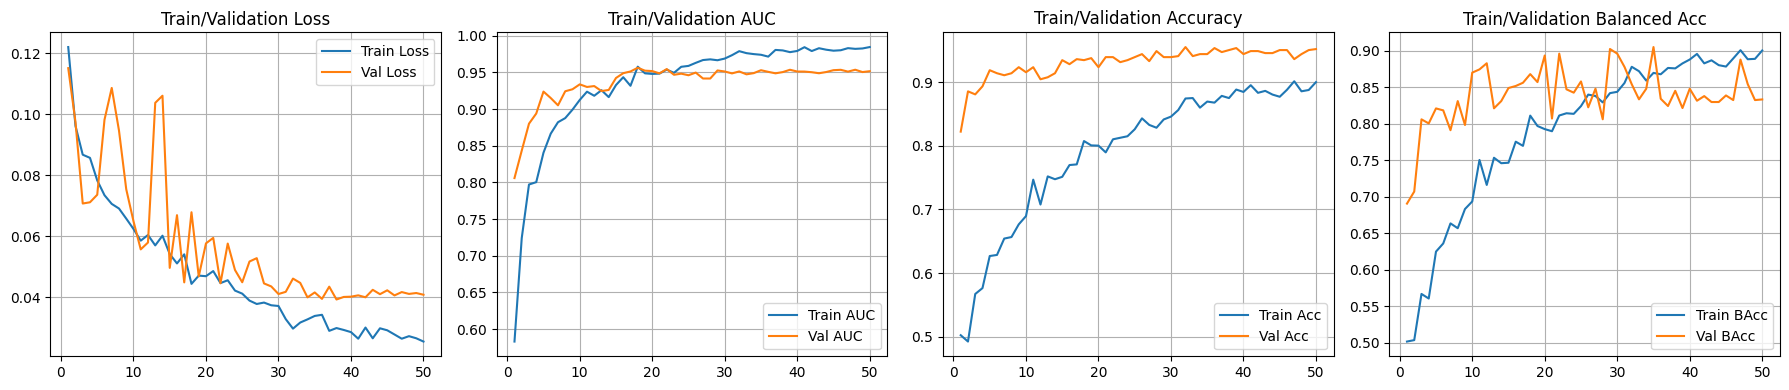

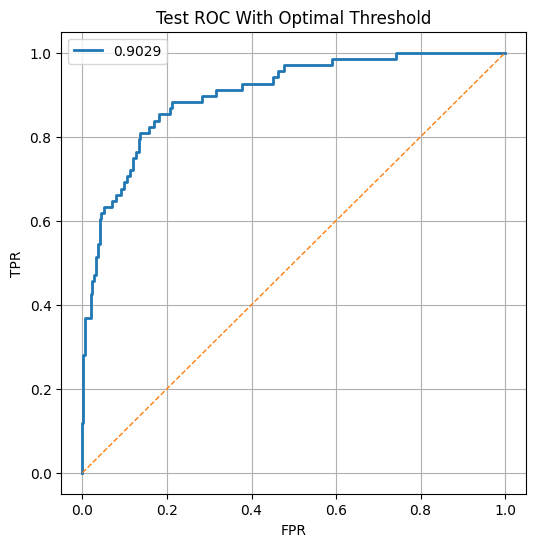

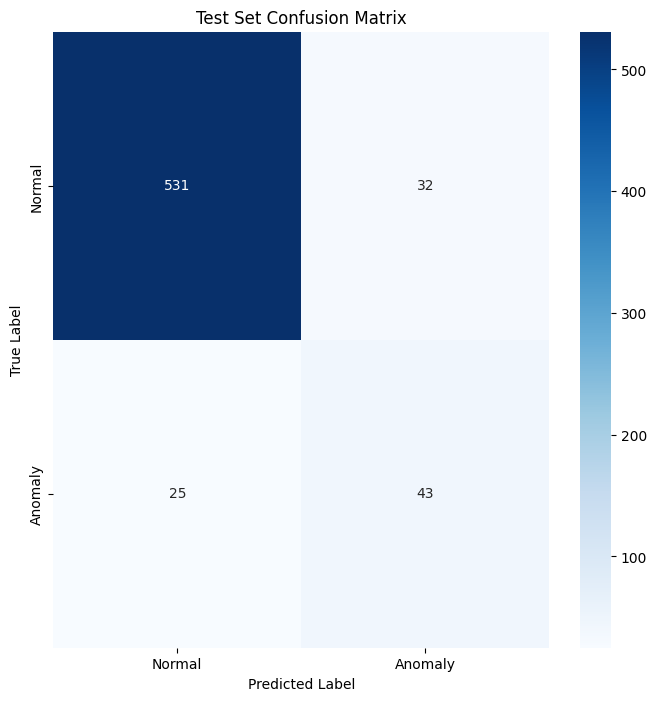

Saved 8 GradCAM images to F:\Capstone\DFCA\checkpoints\DFCA\[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)\ComplexMLP-75\gradcam


In [6]:
# ================================
# Main Pipeline 
# ================================
def main():
    
    SEED = 42
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    train_transforms = ComposeT([
        ToTensor(),
        SpecTimePitchWarp(max_time_scale=1.1, max_freq_scale=1.1),
        SpecAugment(freq_mask_param=4, time_mask_param=4, n_freq_masks=1, n_time_masks=1),
    ])

    no_transform = ComposeT([
        ToTensor(),
    ])

    full_dataset = PairedSpectrogramDataset(FEATURES_DIR, transform=None)
    all_labels = [int(x) for x in full_dataset.labels]

    #Stratified Split [train/val/test]
    idxs = list(range(len(full_dataset)))
    train_idx, temp_idx = train_test_split(idxs, test_size=0.3, stratify=all_labels, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[all_labels[i] for i in temp_idx], random_state=42)
    
    train_set = Subset(PairedSpectrogramDataset(FEATURES_DIR, transform=train_transforms), train_idx)
    val_set = Subset(PairedSpectrogramDataset(FEATURES_DIR, transform=no_transform), val_idx)
    test_set = Subset(PairedSpectrogramDataset(FEATURES_DIR, transform=no_transform), test_idx)
    
    # Added the sampler
    train_labels = [all_labels[i] for i in train_idx]
    counts = np.bincount(train_labels)
    class_wgts = 1.0 / counts
    sample_wgts = [float(class_wgts[label]) for label in train_labels ]
    sampler = WeightedRandomSampler(
        weights=sample_wgts, 
        num_samples=len(sample_wgts), 
        replacement=True
    )
    # Added the sampler
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # normal_transform = ComposeT([
    #     ToTensor()
    # ])

    # abnormal_transform = ComposeT([
    #     ToTensor(),
    #     SpecTimePitchWarp(max_time_scale=1.1, max_freq_scale=1.1),
    #     SpecAugment(freq_mask_param=4, time_mask_param=4, n_freq_masks=1, n_time_masks=1),
    # ])

    # class_to_transform = {
    #     0: normal_transform,
    #     1: abnormal_transform
    # }

    # full_dataset = PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform=None)
    # all_labels = [int(x) for x in full_dataset.labels] 

    # idxs = list(range(len(full_dataset)))
    # train_idx, temp_idx = train_test_split(idxs, test_size=0.3, stratify=all_labels, random_state=42)
    # val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[all_labels[i] for i in temp_idx], random_state=42)

    # train_set = Subset(PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform=class_to_transform), train_idx)
    # val_set   = Subset(PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform={0: normal_transform, 1: normal_transform}), val_idx)
    # test_set  = Subset(PairedSpectrogramDatasetCS(FEATURES_DIR, class_to_transform={0: normal_transform, 1: normal_transform}), test_idx)

    # # --- Dataloaders ---
    # train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    # val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    # test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 
    
    print(f"Split sizes => Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
    print("Label Distribution (Train):",Counter([int(full_dataset[i]['label']) for i in train_idx]))
    print("Label Distribution (Validation):",Counter([int(full_dataset[i]['label']) for i in val_idx]))
    print("Label Distribution (Test):",Counter([int(full_dataset[i]['label']) for i in test_idx]))
    
    head_mode = HEAD_MODE.lower()
    
    if head_mode == 'prototype':
        head = AnomalyScorer(in_dim=256, dropout=0.4, mode='prototype')
        criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)
        print(f"Used head:\n {head}")
        print("Used transformations:")
        for transform in train_transforms.transforms:
            # Print the name of the transformation class
            print(f"  - {transform.__class__.__name__}")
    
            # Check for specific transformations and print their parameters
            if isinstance(transform, SpecTimePitchWarp):

                print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
                print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
            if isinstance(transform, SpecAugment):
                print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
                print(f"    - time_mask_param: {getattr(transform,'time_mask_param',{transform.tm})}")
                print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks', {transform.nf})}")
                print(f"    - n_time_masks: {getattr(transform,'n_time_masks', {transform.nt})}")
    elif HEAD_MODE == 'mlp':
        #head = SimpleAnomalyMLP(in_dim=256, dropout=0.4,hidden=128, out_dim=1)
        head = ComplexAnomalyMLP(in_dim=256, dropout=0.4, out_dim=1)
        pos_count = sum(all_labels)
        neg_count = len(all_labels) - pos_count
        pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32).to(device)
        criterion = BinaryFocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight, reduction='mean')
        # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        print(f"Used head:\n {head}")
        print("Used transformations:")
        for transform in train_transforms.transforms:
            # Print the name of the transformation class
            print(f"  - {transform.__class__.__name__}")
    
            # Check for specific transformations and print their parameters
            if isinstance(transform, SpecTimePitchWarp):

                print(f"    - time_scale: {getattr(transform, 'max_time_scale',{transform.max_time} )}")
                print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
            if isinstance(transform, SpecAugment):
                print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
                print(f"    - time_mask_param: {getattr(transform,'time_mask_param',{transform.tm})}")
                print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
                print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    elif HEAD_MODE == 'embedding':
        head = EmbeddingMLP(in_dim=256, hidden=128, dropout=0.4, emb_dim=64)
        criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)
        print(f"Used head:\n {head}")
        print("Used transformations:")
        for transform in train_transforms.transforms:
            # Print the name of the transformation class
            print(f"  - {transform.__class__.__name__}")
    
            # Check for specific transformations and print their parameters
            if isinstance(transform, SpecTimePitchWarp):

                print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
                print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
            if isinstance(transform, SpecAugment):
                print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
                print(f"    - time_mask_param: {getattr(transform,'time_mask_param',{transform.tm})}")
                print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
                print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    elif HEAD_MODE == 'classifier':
        head = SimpleAnomalyMLP(in_dim=256, dropout=0.4, hidden=128, out_dim=2)
        class_counts = [2624, 319]
        
        alpha = 0.7
        total = sum(class_counts)
        class_weights = [(total / c) ** alpha for c in class_counts]  
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print(f"Using head: {head}")
        print("Used transformations:")
        for transform in train_transforms.transforms:
            # Print the name of the transformation class
            print(f"  - {transform.__class__.__name__}")
    
            # Check for specific transformations and print their parameters
            if isinstance(transform, SpecTimePitchWarp):

                print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
                print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
            if isinstance(transform, SpecAugment):
                print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
                print(f"    - time_mask_param: {getattr(transform,'time_mask_param', {transform.tm})}")
                print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
                print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    elif HEAD_MODE == 'classifier-1':
        head = AnomalyScorer(in_dim=256, dropout=0.4, mode='classifier-1')
        pos_count = sum(all_labels)
        neg_count = len(all_labels) - pos_count
        pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        print(f"Using head: \n{head}")
        print("Used transformations:")
        for transform in train_transforms.transforms:
            print(f"- {transform.__class__.__name__}")
            if isinstance(transform, SpecTimePitchWarp):

                print(f"    - time_scale: {getattr(transform, 'max_time_scale', {transform.max_time})}")
                print(f"    - freq_scale: {getattr(transform, 'max_freq_scale', {transform.max_freq})}")
            if isinstance(transform, SpecAugment):
                print(f"    - freq_mask_param: {getattr(transform,'freq_mask_param',{transform.fm})}")
                print(f"    - time_mask_param: {getattr(transform,'time_mask_param', {transform.tm})}")
                print(f"    - n_freq_masks: {getattr(transform,'n_freq_masks',{transform.nf})}")
                print(f"    - n_time_masks: {getattr(transform,'n_time_masks',{transform.nt})}")
    else:
        raise ValueError("Invalid Head_Mode")
    
    model = FusedModel(
        stft_dim=512, cqt_dim=320, fusion_dim=256, head=head, head_mode=head_mode,
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
    
    model_path = os.path.join(CHECKPOINT_DIR, 'DFCA', '[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)','ComplexMLP-75', "best_model.pth")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  
    best_threshold = train_model(model, train_loader, val_loader, criterion, optimizer, head_mode, scheduler, num_epochs=NUM_EPOCHS, model_save_path=model_path, device=device, save_plots=True)
    
    print("\n--- Final Test Evaluation ---")
    model.load_state_dict(torch.load(model_path))
    
    safe_threshold = float(best_threshold) if best_threshold is not None else 0.5

    test_loss, test_auc, test_acc, test_bacc, test_f1, all_labels_test, all_probs_test, _ = evaluate_model(model, test_loader, criterion, "Test", device, head_mode=head_mode, sample_count=5, threshold=safe_threshold)
    print(f"\nFinal Test Metrics (with best validation threshold {best_threshold:.2f}):")
    print(f"Loss: {test_loss:.4f} | AUC: {test_auc:.4f} | Accuracy: {test_acc:.4f} | Balanced Accuracy: {test_bacc:.4f} | F1-Score: {test_f1:.4f}")
    if len(np.unique(all_labels_test)) > 1:
        final_pauc = calculate_pAUC(all_labels_test, all_probs_test, max_fpr=0.2)
        print(f"Final Test pAUC (FPR <= 0.2): {final_pauc:.4f}")
    else:
        print("Test set contains only one class; cannot compute AUC/pAUC")


    # Plot ROC
    fpr, tpr, _ = roc_curve(all_labels_test, all_probs_test)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f"{test_auc:.4f}")
    plt.plot([0,1],[0,1], linestyle='--', lw=1)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Test ROC With Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path,"roc_test_optimal.png"))
    # plt.show()

    labels = ['Normal', 'Anomaly']
    all_preds_test = (np.array(all_probs_test) > safe_threshold).astype(int)
    plot_confusion_matrix(all_labels_test, all_preds_test,labels,save_path,title='Test Set Confusion Matrix')

    try:
        cams = build_gradcam_for_model(model, device)
        run_and_save_gradcams(model, cams, test_set,device, out_dir=os.path.join(CHECKPOINT_DIR,'DFCA','[Anomaly-With-Transformations-dropout=0.4]_MLP(5e-5)','ComplexMLP-75','gradcam'),n_samples=8)
    except Exception as error:
        print(f"GradCAM step failed: {error}")

if __name__ == '__main__':
    main()